In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append(os.pardir)

from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

In [4]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # 계층
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads

    def gradient(self, x, t):
        self.loss(x, t)

        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads

In [8]:
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(f'{key}: {str(diff)}')

W1: 4.463863460020872e-10
b1: 2.747141536621825e-09
W2: 4.994908828030844e-09
b2: 1.3979238249889337e-07


In [20]:
import tensorflow as tf


(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 1000
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
with tf.device('/GPU:0'):
    for i in range(iters_num):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        grad = network.gradient(x_batch, t_batch)

        for key in ('W1', 'b1', 'W2', 'b2'):
            network.params[key] -= learning_rate * grad[key]

        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)

        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            test_acc = network.accuracy(x_test, t_test)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
            print(f'epoch {int(i / iter_per_epoch)}', end=' ')
            print(f'train_acc: {train_acc*100:.2f}%, test_acc: {test_acc*100:.2f}%')

epoch 0 train_acc: 12.41%, test_acc: 12.53%
epoch 1 train_acc: 53.41%, test_acc: 53.83%
epoch 2 train_acc: 78.17%, test_acc: 79.02%
epoch 3 train_acc: 84.06%, test_acc: 84.63%
epoch 4 train_acc: 86.78%, test_acc: 87.27%
epoch 5 train_acc: 88.30%, test_acc: 88.77%
epoch 6 train_acc: 89.10%, test_acc: 89.44%
epoch 7 train_acc: 89.74%, test_acc: 89.96%
epoch 8 train_acc: 90.07%, test_acc: 90.36%
epoch 9 train_acc: 90.27%, test_acc: 90.65%
epoch 10 train_acc: 90.70%, test_acc: 91.05%
epoch 11 train_acc: 90.89%, test_acc: 91.26%
epoch 12 train_acc: 91.14%, test_acc: 91.43%
epoch 13 train_acc: 91.39%, test_acc: 91.66%
epoch 14 train_acc: 91.50%, test_acc: 91.68%
epoch 15 train_acc: 91.65%, test_acc: 91.73%
epoch 16 train_acc: 91.86%, test_acc: 92.04%
epoch 17 train_acc: 91.96%, test_acc: 92.09%
epoch 18 train_acc: 92.14%, test_acc: 92.29%
epoch 19 train_acc: 92.32%, test_acc: 92.46%
epoch 20 train_acc: 92.42%, test_acc: 92.61%
epoch 21 train_acc: 92.53%, test_acc: 92.72%
epoch 22 train_acc: 

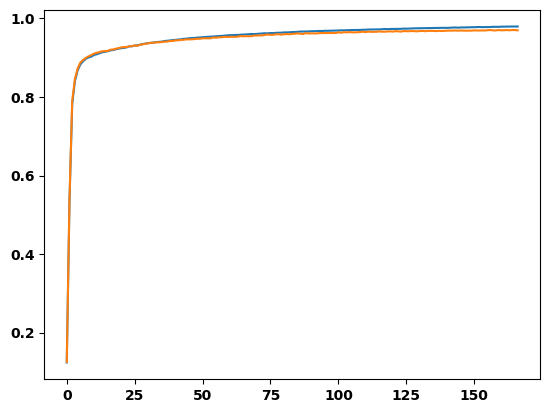

In [21]:
plt.plot(train_acc_list)
plt.plot(test_acc_list)
plt.show()

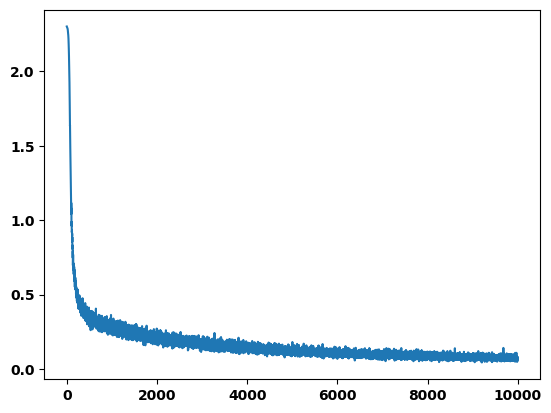

In [22]:
plt.plot(train_loss_list)
plt.show()